# Text-prompted zero-shot object detection by hand

# Imports

In [1]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
# loading the model and associated processor
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

checkpoint = "google/owlvit-base-patch32"
processor = AutoProcessor.from_pretrained(checkpoint)
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

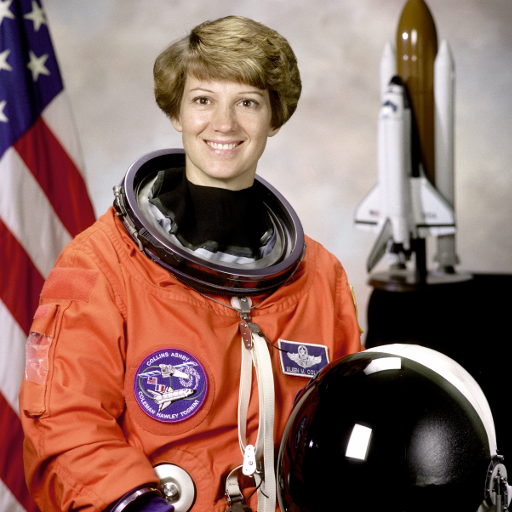

In [8]:
# Let’s take an image
import skimage
import numpy as np
from PIL import Image, ImageDraw
import requests

image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

image

In [7]:
# Use the processor to prepare the inputs for the model
text_queries = ["human face", "rocket", "nasa badge", "star-spangled banner"]
inputs = processor(
    text=text_queries,
    images=image,
    return_tensors="pt",
)

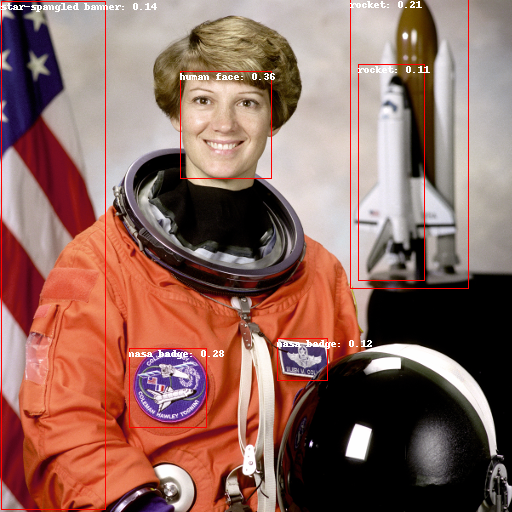

In [11]:
# Pass the inputs through the model, post-process, and visualize the results
import torch

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(
        outputs,
        threshold=0.1,
        target_sizes=target_sizes,
    )[0]

draw = ImageDraw.Draw(image)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score, 2)}", fill="white")

image

## Batch processing

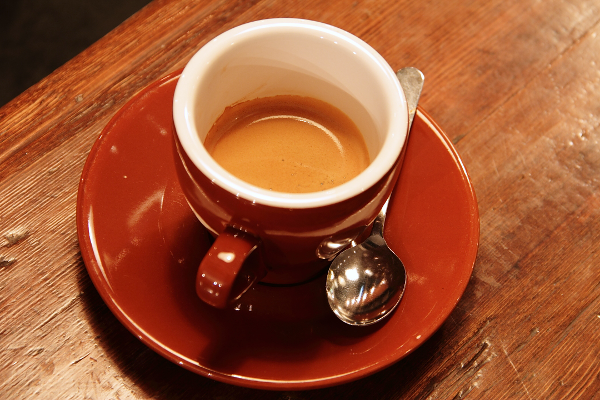

In [13]:
image2 = skimage.data.coffee()
image2 = Image.fromarray(np.uint8(image2)).convert("RGB")

image2

In [21]:
images = [image, image2]
text_queries = [
    ["human face", "rocket", "nasa badge", "star-spangled banner"],
    ["coffee beans", "coffee cup", "coffee pot", "coffee table"],
]

inputs = processor(text=text_queries, images=images, return_tensors="pt")

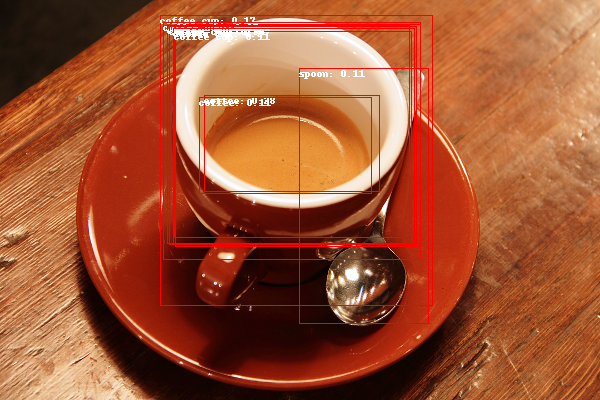

In [22]:
# Pass the inputs through the model, post-process, and visualize the results
with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = [x.size[::-1] for x in images]
    results = processor.post_process_object_detection(
        outputs=outputs,
        threshold=0.1,
        target_sizes=target_sizes,
    )

image_idx = 1
draw = ImageDraw.Draw(images[image_idx])

scores = results[image_idx]["scores"].tolist()
labels = results[image_idx]["labels"].tolist()
boxes = results[image_idx]["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[image_idx][label]}: {round(score, 2)}", fill="white")

images[image_idx]

## Image-guided object detection

In [23]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_target = Image.open(requests.get(url, stream=True).raw)

query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

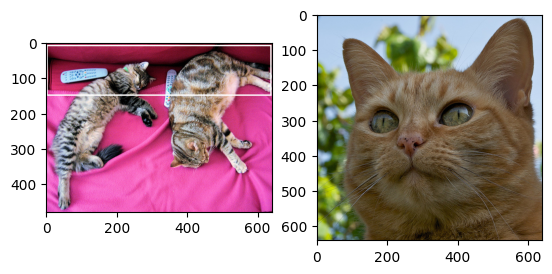

In [29]:
# Let’s take a quick look at the images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)

In [30]:
# Preprocess the input images
inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")

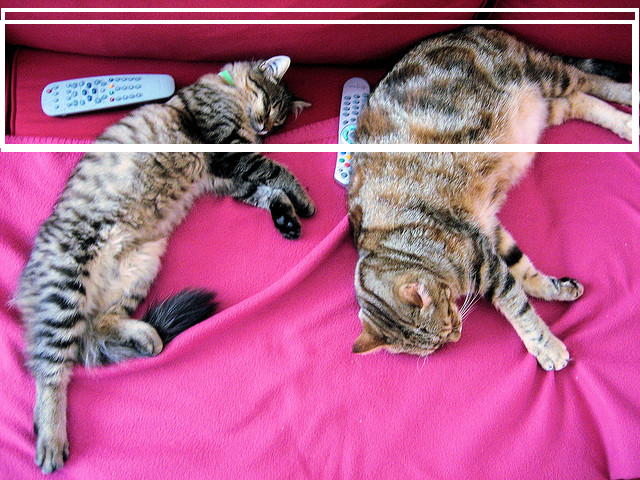

In [31]:
# Pass the inputs through the model, post-process, and visualize the results
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(image_target)

scores = results["scores"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="white", width=4)

image_target